In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import entropy
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
import matplotlib.transforms

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
import populations.bbh_models as read_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde
from populations import gw_obs

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'CE'
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']

In [3]:
params = ['mchirp','q', 'chieff', 'z']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'

model_names, flow = read_models.get_models(file_path, [channel_label], params, use_flows=True, device='cpu', no_bins=[5], use_unityweights=False)
_, KDE = read_models.get_models(file_path, [channel_label], params, use_flows=False, device='cpu', use_unityweights=False)

#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


In [4]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_150124_extralong/flow_models/"
flow[channel_label].load_model(flow_path, channel_label)

In [5]:
np.random.seed(8675309)
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

In [22]:
no_samples =100000
flow_KDE_KL = np.zeros((4,5))
KDE_flow_KL = np.zeros((4,5))

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):

        p_flow = np.exp(flow[channel_label](obsdata, np.array([chi_b_id,alpha_id]), 990903, p_theta))

        p_KDE = KDE[channel_label][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]](obsdata, 990903, p_theta)


        flow_KDE_KL[chi_b_id,alpha_id] = entropy(p_flow, p_KDE)
        KDE_flow_KL[chi_b_id,alpha_id] = entropy(p_KDE, p_flow)
        print(flow_KDE_KL[chi_b_id,alpha_id])

        

0.8595014137046703
0.08612632057329647
0.2578115579641542
0.205736647318159
0.15187822860594635
1.0386097073064728
0.23178008108870765
0.387927837752355
0.3866217896246838
0.15366383680939785
0.8064161169573922
0.3963704384962593
0.7911051677990947
0.6355253681327733
0.41910438914108655
0.19489733451151103
0.5454980765276766
0.41143034438470777
0.3917898104201815
1.3831103420565019


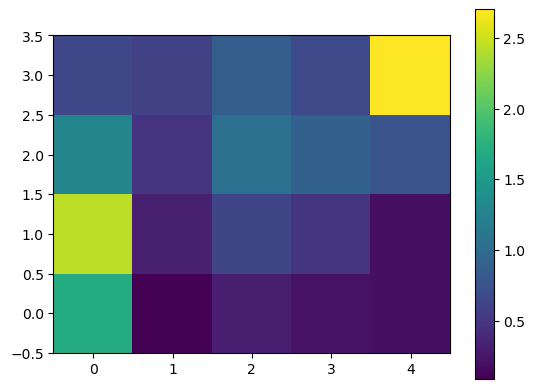

In [34]:
plt.imshow(KDE_flow_KL, origin='lower')
plt.colorbar()

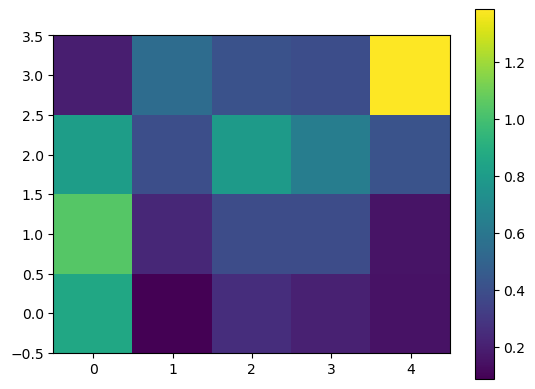

In [35]:
plt.imshow(flow_KDE_KL, origin='lower')
plt.colorbar()

In [5]:
np.random.seed(8675309)

In [196]:
no_samples =1000
flow_KL = np.zeros((4,5))
model_samples = np.zeros((4,5,no_samples,4))
model_weights = np.zeros((4,5,no_samples))

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        model_samples_idx = np.random.choice(np.shape(models_dict[(chi_b_id,alpha_id)])[0], no_samples)#, \
            #p=weights_dict[(chi_b_id,alpha_id)]/np.sum(weights_dict[(chi_b_id,alpha_id)]))
        model_samples[chi_b_id,alpha_id,:,:] = np.array(models_dict[(chi_b_id,alpha_id)])[model_samples_idx]
        model_weights[chi_b_id,alpha_id,:] = np.array(weights_dict[(chi_b_id,alpha_id)])[model_samples_idx]

In [203]:
for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        _,_,_,_,p_flow = flow[channel_label](np.reshape(model_samples[chi_b_id,alpha_id],(no_samples,1,4)), np.array([chi_b_id,alpha_id]), 990903)
        flow_KL[chi_b_id,alpha_id] = np.mean(model_weights[chi_b_id,alpha_id]*np.exp(p_flow)/np.sum(model_weights[chi_b_id,alpha_id]))

tensor(1.0924)
tensor(-2.3267)
[[-3.89029977e-01]
 [-3.63804276e+00]
 [-6.93050475e+00]
 [-4.55340757e-01]
 [-2.96438985e+00]
 [-1.94940579e+00]
 [-8.28261946e+00]
 [ 7.43117757e-01]
 [-6.61152160e+00]
 [-5.09885232e+00]
 [-6.82361807e-01]
 [ 5.17494197e+00]
 [-2.25938170e+00]
 [-5.73063651e+00]
 [-6.37396628e-01]
 [-3.73080961e+00]
 [ 2.55296233e+00]
 [-8.99658638e-01]
 [-3.24178695e+00]
 [ 1.31722472e+00]
 [-2.70616790e+00]
 [-5.09406329e+00]
 [ 1.59287182e+00]
 [-1.33408462e-01]
 [-7.25089227e+00]
 [-3.43580598e+00]
 [-5.73045346e+00]
 [-7.44686910e+00]
 [ 5.62947077e+00]
 [-3.11088248e-03]
 [ 1.98011740e+00]
 [-4.31519925e+00]
 [ 2.17161614e+00]
 [-7.36822382e+00]
 [-3.87413703e+00]
 [-2.62762157e+00]
 [ 2.04608591e+00]
 [-3.63553326e+00]
 [-1.62467736e+00]
 [-4.08380530e+00]
 [-2.26324690e+00]
 [ 1.74583590e+00]
 [-3.68002997e+00]
 [-8.42619429e+00]
 [ 2.97639370e+00]
 [ 6.24938578e+00]
 [-3.18327859e+00]
 [ 1.63154282e+00]
 [ 2.86634350e+00]
 [ 5.58850092e+00]
 [-2.44438158e+00]


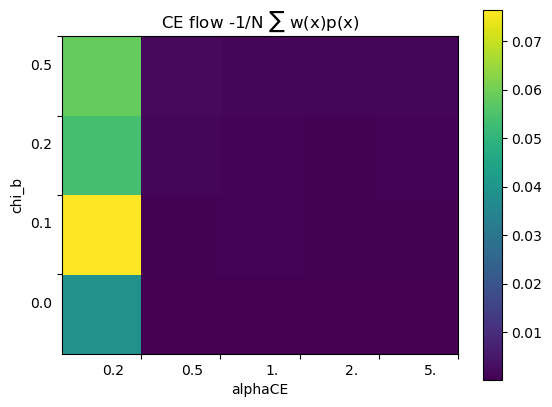

In [204]:

fig,ax=plt.subplots(1,1)
plt.imshow(flow_KL, origin='lower', extent=(0,5,0,4))
plt.colorbar()
plt.title(r'CE flow -1/N $\sum$ w(x)p(x)')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(chi_b)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

In [205]:
kde_KL = np.zeros((4,5))

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        p_kde = KDE[channel_label][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]](np.reshape(model_samples[chi_b_id,alpha_id],(no_samples,1,4)), 990903)
        kde_KL[chi_b_id,alpha_id] = np.mean(model_weights[chi_b_id,alpha_id]*p_kde/np.sum(model_weights[chi_b_id,alpha_id]))
        print(kde_KL)

[[0.00223584 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00223584 0.00013473 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00223584 0.00013473 0.00017577 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00223584 0.00013473 0.00017577 0.00013346 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00223584 0.00013473 0.00017577 0.00013346 0.00015819]
 [0.      

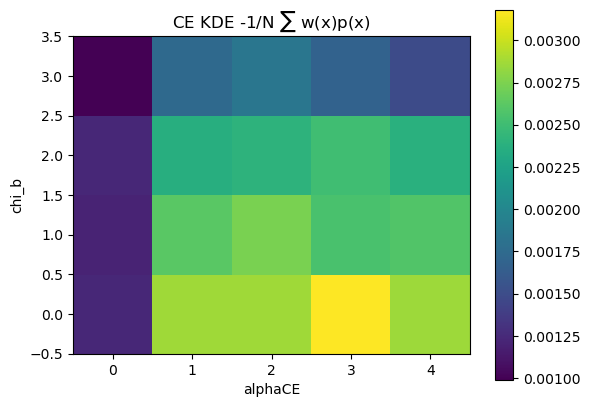

In [201]:
plt.imshow(kde_KL, origin='lower')
plt.colorbar()
plt.title(r'CE KDE -1/N $\sum$ w(x)p(x)')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(chi_b)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

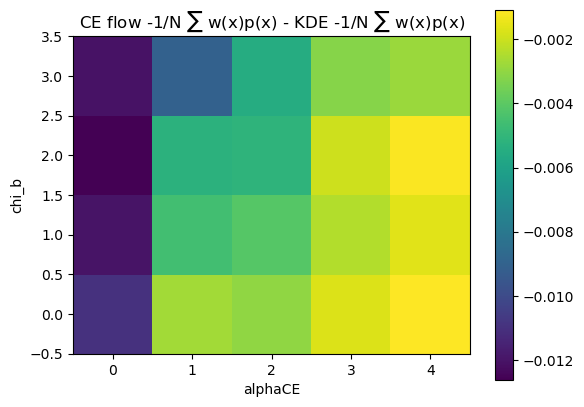

In [95]:
plt.imshow(flow_KL-kde_KL, origin='lower')
plt.colorbar()
plt.title(r'CE flow -1/N $\sum$ w(x)p(x) - KDE -1/N $\sum$ w(x)p(x)')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([1,2,3,4])
ax.set_yticklabels(chi_b)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

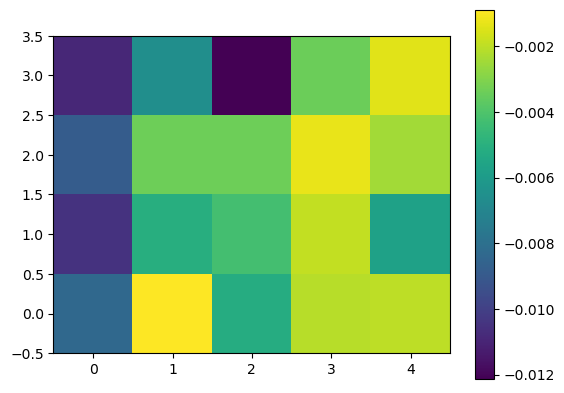

In [79]:
plt.imshow(flow_KL-kde_KL, origin='lower')
plt.colorbar()

## Non-CE

In [168]:
no_samples =1000
flow_KL = np.zeros((4))
model_samples = np.zeros((4,no_samples,4))
model_weights = np.zeros((4,no_samples))

for chi_b_id, xb in enumerate(chi_b):
    model_samples_idx = np.random.choice(np.shape(models_dict[(chi_b_id)])[0], no_samples)#, \
        #p=weights_dict[(chi_b_id,alpha_id)]/np.sum(weights_dict[(chi_b_id,alpha_id)]))
    model_samples[chi_b_id,:,:] = np.array(models_dict[(chi_b_id)])[model_samples_idx]
    model_weights[chi_b_id,:] = np.array(weights_dict[(chi_b_id)])[model_samples_idx]

In [169]:
for chi_b_id, xb in enumerate(chi_b):
    p_flow = flow[channel_label](np.reshape(model_samples[chi_b_id],(no_samples,1,4)), np.array([chi_b_id]), 990903)
    flow_KL[chi_b_id] = -1/no_samples * np.sum(model_weights[chi_b_id]*p_flow)

In [170]:
flow_KL

array([-0.00212038, -0.00237968, -0.00259865, -0.00157585])

In [171]:
kde_KL = np.zeros((4))

for chi_b_id, xb in enumerate(chi_b):
        p_kde = KDE[channel_label][submodels_dict[0][chi_b_id]](np.reshape(model_samples[chi_b_id],(no_samples,1,4)), 990903)
        kde_KL[chi_b_id] = -1/no_samples * np.sum(model_weights[chi_b_id]*np.log(p_kde))
        print(kde_KL)

[-0.00032717  0.          0.          0.        ]
[-0.00032717 -0.00027497  0.          0.        ]
[-0.00032717 -0.00027497  0.00055194  0.        ]
[-0.00032717 -0.00027497  0.00055194  0.00064599]


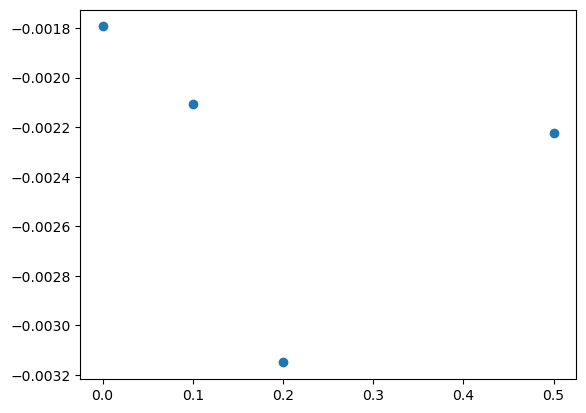

In [172]:
plt.scatter(chi_b, flow_KL-kde_KL)

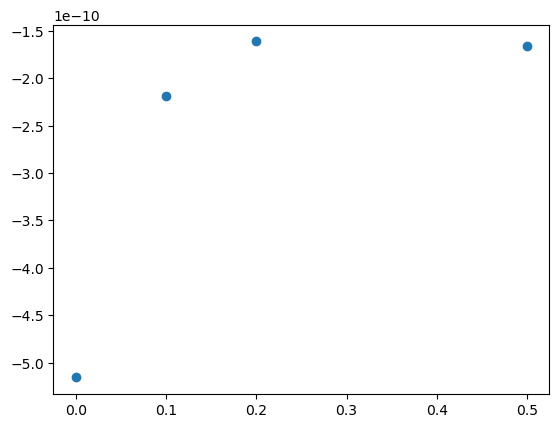

In [157]:
plt.scatter(chi_b, flow_KL-kde_KL)

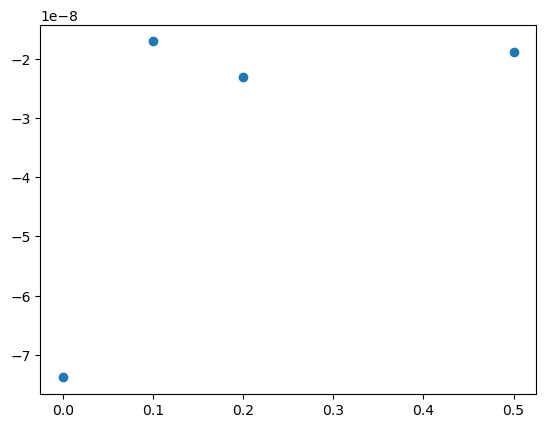

In [144]:
plt.scatter(chi_b, flow_KL-kde_KL)

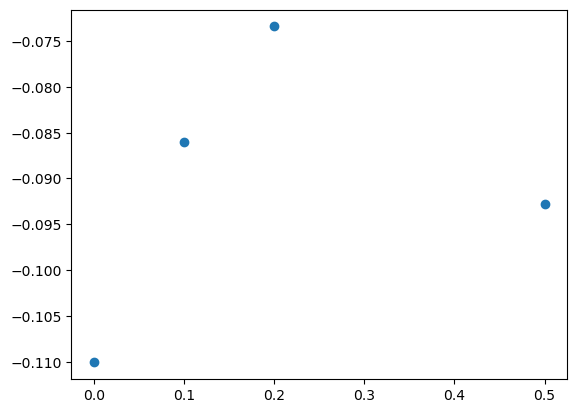

In [136]:
plt.scatter(chi_b, flow_KL-kde_KL)

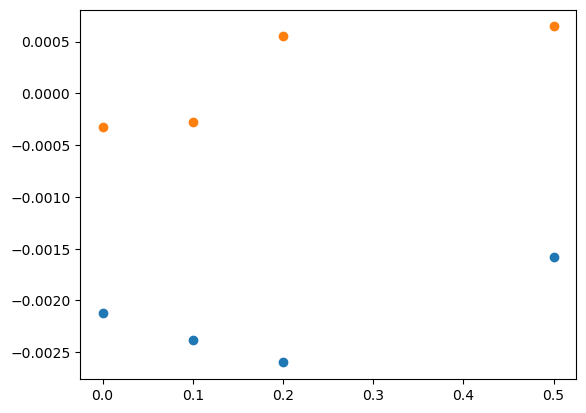

In [173]:
plt.scatter(chi_b, flow_KL)
plt.scatter(chi_b, kde_KL)

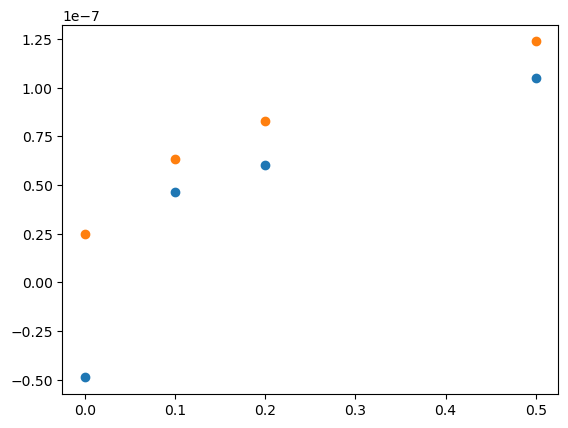

In [147]:
plt.scatter(chi_b, flow_KL)
plt.scatter(chi_b, kde_KL)

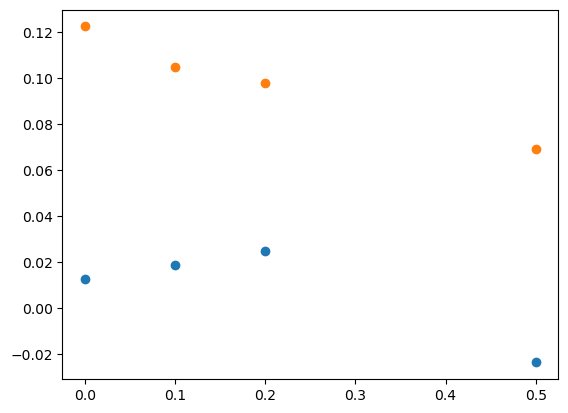

In [137]:
plt.scatter(chi_b, flow_KL)
plt.scatter(chi_b, kde_KL)